In [1]:
# 忽略warnings
import warnings 
warnings.filterwarnings('ignore') 

# 导入Python通用库
import matplotlib.pyplot as plt
import numpy as np

# 导入TF_2.0并设置GPU
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# gpus= tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)
# 导入Keras库
from tensorflow import keras
# 设置使用GPU显存的比例
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config)) 

# 导入util模块的各种方法
# from tensorflow.keras.utils.np_utils import to_categorical
# 加载训练好的模块
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
# 导入数据集
# from keras.datasets import imdb
from tensorflow.keras.datasets import mnist
# 导入模型、优化器、损失函数等等
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import layers
# 导入Keras图像处理模块
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
# 导入系统库
import os
# 导入opencv
import cv2

Using TensorFlow backend.


# 05. 深度学习用于计算机视觉
卷积神经网络，也叫`convnet`，是计算机视觉应用几乎都在使用的一种深度学习模型。你将学到将卷积神经网络应用于图像分类问题，特别是那些训练数据集较小的问题。如果你工作的地方并非大型科技公司，这也将是你最常见的使用场景。

## 5.4 卷积神经网络的可视化
人们常说，深度学习模型是“黑盒”，即模型学到的表示很难用人类可以理解的方式来提取和呈现。这种说法部分正确。卷积神经网络学到的表示非常适合可视化，很大程度上是因为它们是视觉概念的表示。

自2013年以来，人们开发了多种技术来对这些表示进行可视化和解释。我们不会在书中全部介绍，但会介绍三种最容易理解也最有用的方法：
+ **可视化卷积神经网络的中间输出（中间激活）**：有助于理解卷积神经网络连续的层如何对输入进行变换，也有助于初步了解卷积神经网络每个过滤器的含义
+ **可视化卷积神经网络的过滤器**：有助于精确理解卷积神经网络中每个过滤器容易接受的视觉模式或视觉概念
+ **可视化图像中类激活的热力图**：有助于理解图像的哪个部分被识别为属于某个类别，从而可以定位图像中的物体

对于第一种方法（即激活的可视化），我们将使用`5.2`节在猫狗分类问题上从头开始训练的小型卷积神经网络。对于另外两种可视化方法，我们将使用`5.3`节介绍的`VGG16`模型。

### 5.4.1 可视化中间激活
可视化中间激活，是指对于给定输入，展示网络中各个卷积层和池化层输出的特征图（层的输出通常被称为该层的激活，即激活函数的输出）。这让我们可以看到输入如何被分解为网络学到的不同过滤器。我们希望在三个维度对特征图进行可视化：宽度、高度和深度（通道）。每个通道都对应相对独立的特征，所以将这些特征图可视化的正确方法是将每个通道的内容分别绘制成二维图像。我们首先来加载`5.2`节保存的模型。

In [2]:
model = load_model('./model/cats_and_dogs_small_2.h5')
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 128)       0         
_______________________________________

接下来，我们需要一张输入图像，即一张猫的图像，它不属于网络的训练图像。

In [3]:
img = image.load_img('./data/cat.1700.jpg', target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
img_tensor.shape

(1, 150, 150, 3)

显示测试图像：

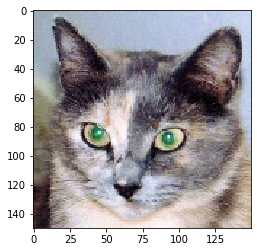

In [4]:
plt.imshow(img_tensor[0])
plt.show()

为了提取想要查看的特征图，我们需要创建一个`Keras`模型，以图像批量作为输入，并输出所有卷积层和池化层的激活。为此，我们需要使用`Keras`的`Model`类。模型实例化需要两个参数：一个输入张量（或输入张量的列表）和一个输出张量（或输出张量的列表）。得到的类是一个`Keras`模型，就像你熟悉的`Sequential`模型一样，将特定输入映射为特定输出。`Model`类允许模型有多个输出，这一点与`Sequential`模型不同。

In [5]:
# 提取前8层的输出
layer_outputs = [layer.output for layer in model.layers[:8]]
# 创建一个模型，给定模型输入，可以返回这些输出
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

输入一张图像，这个模型将返回原始模型前8层的激活值。这是你在本书中第一次遇到的多输出模型，之前的模型都是只有一个输入和一个输出。一般情况下，模型可以有任意个输入和输出。这个模型有一个输入和8个输出，即每层激活对应一个输出。

In [6]:
# 返回8个Numpy数组组成的列表，每个层激活对应一个Numpy数组
activations = activation_model.predict(img_tensor)

对于输入的猫图像，第一个卷积层的激活如下所示。

In [7]:
first_layer_activation = activations[0]
first_layer_activation.shape

(1, 148, 148, 32)

它是大小为$148 \times 148$的特征图，有32个通道。我们来绘制原始模型第一层激活的第0个通道：

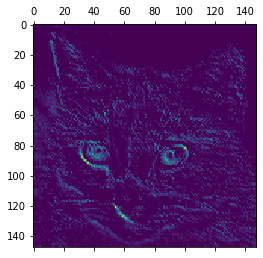

In [8]:
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis');

这个通道似乎是对角边缘检测器。我们再看一下第20个通道。但请注意，你的通道可能与此不同，因为卷积层学到的过滤器并不是确定的。

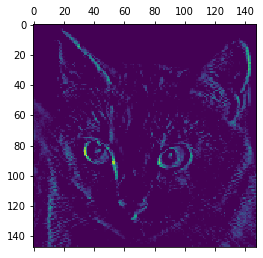

In [9]:
plt.matshow(first_layer_activation[0, :, :, 20], cmap='viridis');

这个通道看起来像是“鲜绿色圆点”检测器，对寻找猫眼睛很有用。下面我们来绘制网络中所有激活的完整可视化。我们需要在 8 个特征图中的每一个中提取并绘制每一个通道，然后将结果叠加在一个大的图像张量中，按通道并排。

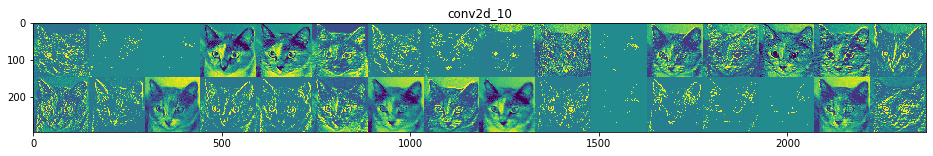

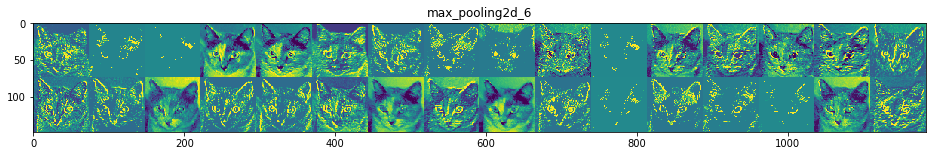

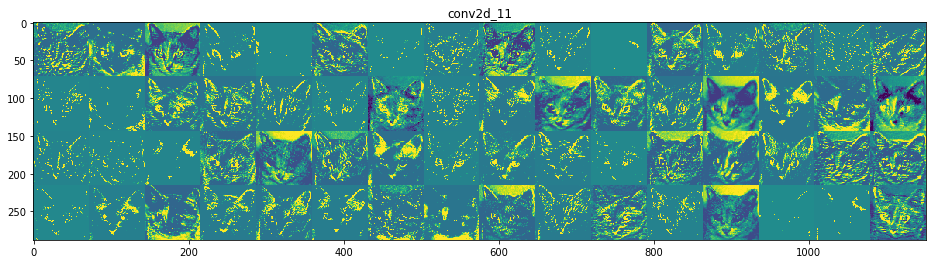

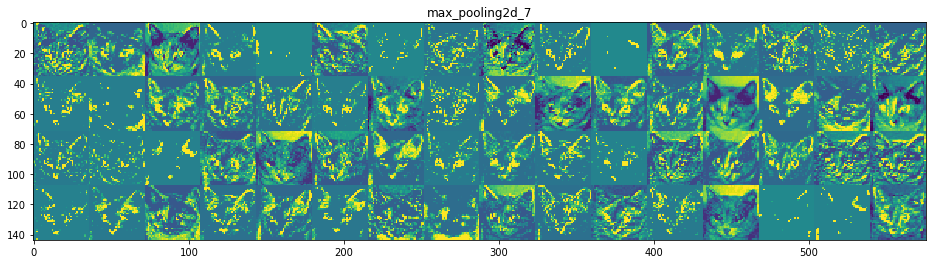

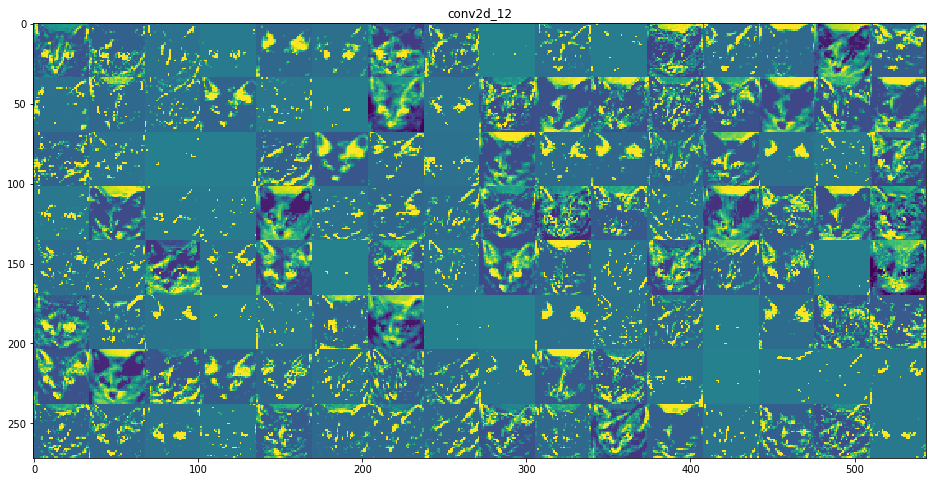

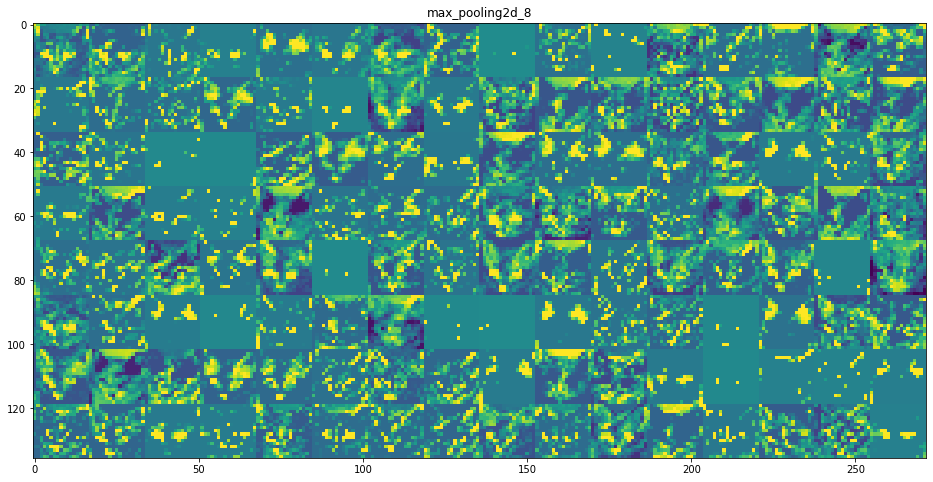

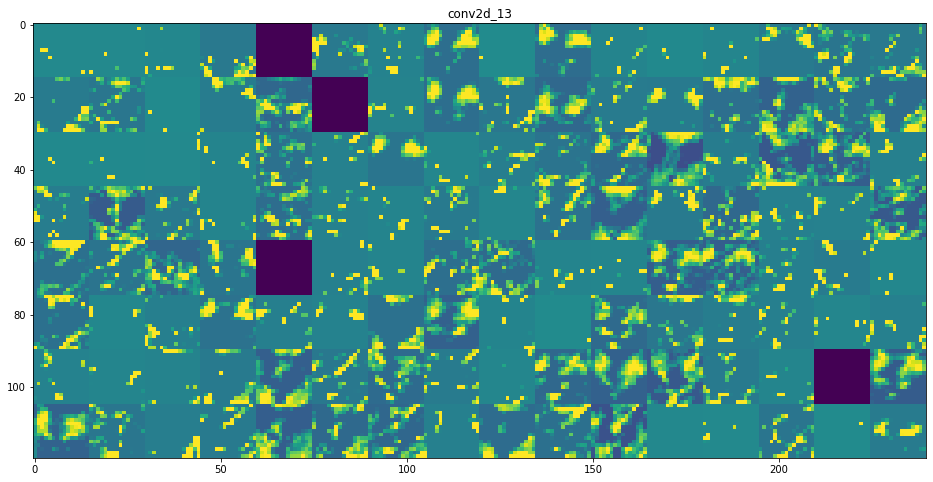

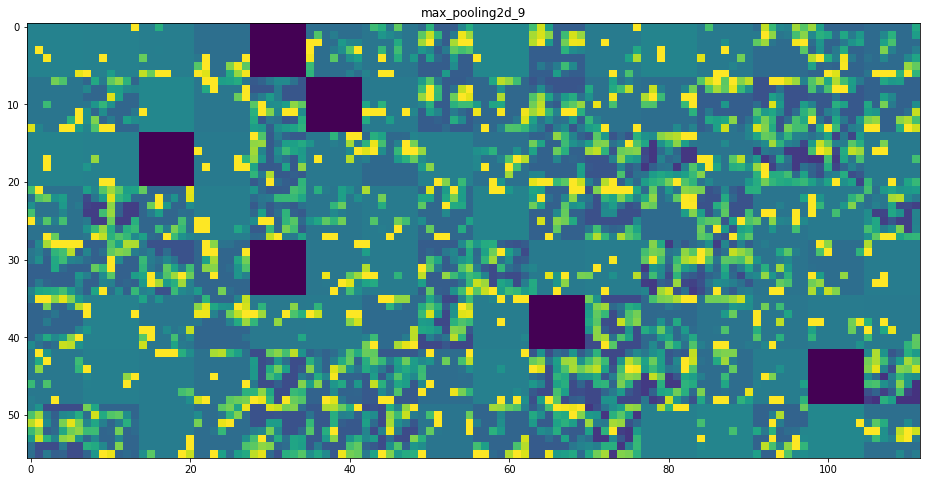

In [10]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]
    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

这里需要注意以下几点：
+ 第一层是各种边缘探测器的集合。在这一阶段，激活几乎保留了原始图像中的所有信息
+ 随着层数的加深，激活变得越来越抽象，并且越来越难以直观地理解。它们开始表示更高层次的概念，比如“猫耳朵”和“猫眼睛”。层数越深，其表示中关于图像视觉内容的信息就越少，而关于类别的信息就越多
+ 激活的稀疏度（sparsity）随着层数的加深而增大。在第一层里，所有过滤器都被输入图像激活，但在后面的层里，越来越多的过滤器是空白的。也就是说，输入图像中找不到这些过滤器所编码的模式

我们刚刚揭示了深度神经网络学到的表示的一个重要普遍特征：随着层数的加深，层所提取的特征变得越来越抽象。更高的层激活包含关于特定输入的信息越来越少，而关于目标的信息越来越多（本例中即图像的类别：猫或狗）。深度神经网络可以有效地作为信息蒸馏管道（information distillation pipeline），输入原始数据（本例中是`RGB`图像），反复对其进行变换，将无关信息过滤掉（比如图像的具体外观），并放大和细化有用的信息（比如图像的类别）。

这与人类和动物感知世界的方式类似：人类观察一个场景几秒钟后，可以记住其中有哪些抽象物体（比如自行车、树），但记不住这些物体的具体外观。事实上，如果你试着凭记忆画一辆普通自行车，那么很可能完全画不出真实的样子，虽然你一生中见过上千辆自行车（见`图5-28`）。你可以现在就试着画一下，这个说法绝对是真实的。你的大脑已经学会将视觉输入完全抽象化，即将其转换为更高层次的视觉概念，同时过滤掉不相关的视觉细节，这使得大脑很难记住周围事物的外观。

<img src="images/05_28.png" style="width:400px;"/>

### 5.4.2 可视化卷积神经网络的过滤器
想要观察卷积神经网络学到的过滤器，另一种简单的方法是显示每个过滤器所响应的视觉模式。这可以通过在输入空间中进行梯度上升来实现：从空白输入图像开始，将梯度下降应用于卷积神经网络输入图像的值，其目的是让某个过滤器的响应最大化。得到的输入图像是选定过滤器具有最大响应的图像。

这个过程很简单：我们需要构建一个损失函数，其目的是让某个卷积层的某个过滤器的值最大化；然后，我们要使用随机梯度下降来调节输入图像的值，以便让这个激活值最大化。例如，对于在`ImageNet`上预训练的`VGG16`网络，其`block3_conv1`层第0个过滤器激活的损失如下所示。

In [11]:
model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])
model

为了实现梯度下降，我们需要得到损失相对于模型输入的梯度。为此，我们需要使用`Keras`的`backend`模块内置的`gradients`函数。

In [12]:
# 对于TF 2.0，下面的代码会报错：
# tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead
# 解决方法：
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()
# 
# 调用gradients返回的是一个张量列表（本例中列表长度为1）。因此，只保留第一个元素，它是一个张量
grads = K.gradients(loss, model.input)[0]

为了让梯度下降过程顺利进行，一个非显而易见的技巧是将梯度张量除以其L2范数（张量中所有值的平方的平均值的平方根）来标准化。这就确保了输入图像的更新大小始终位于相同的范围。

In [13]:
# 做除法前加上1e–5，以防不小心除以0
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

现在你需要一种方法：给定输入图像，它能够计算损失张量和梯度张量的值。你可以定义一个`Keras`后端函数来实现此方法：`iterate`是一个函数，它将一个`Numpy`张量（表示为长度为1的张量列表）转换为两个`Numpy`张量组成的列表，这两个张量分别是损失值和梯度值。

In [14]:
iterate = K.function([model.input], [loss, grads])
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

现在你可以定义一个`Python`循环来进行随机梯度下降。

In [15]:
# We start from a gray image with some noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

得到的图像张量是形状为`(1, 150, 150, 3)`的浮点数张量，其取值可能不是`[0, 255]`区间内的整数。因此，你需要对这个张量进行后处理，将其转换为可显示的图像：

In [16]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

接下来，我们将上述代码片段放到一个Python函数中，输入一个层的名称和一个过滤器索引，它将返回一个有效的图像张量，表示能够将特定过滤器的激活最大化的模式。

In [17]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]
    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    # rebuild the image
    img = input_img_data[0]
    return deprocess_image(img)

我们来试用一下这个函数：

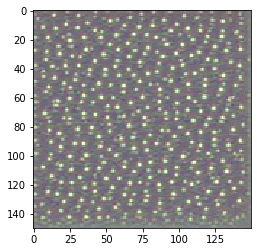

In [18]:
plt.imshow(generate_pattern('block3_conv1', 0));

看起来，`block3_conv1`层第0个过滤器响应的是`波尔卡点`（polka-dot）图案。

下面来看有趣的部分：我们可以将每一层的每个过滤器都可视化。为了简单起见，我们只查看每一层的前64个过滤器，并只查看每个卷积块的第一层（即`block1_conv1`、`block2_conv1`、`block3_conv1`、`block4_conv1`、`block5_conv1`）。我们将输出放在一个$8 \times 8$的网格中，每个网格是一个$64 像素\times 64像素$的过滤器模式，两个过滤器模式之间留有一些黑边：

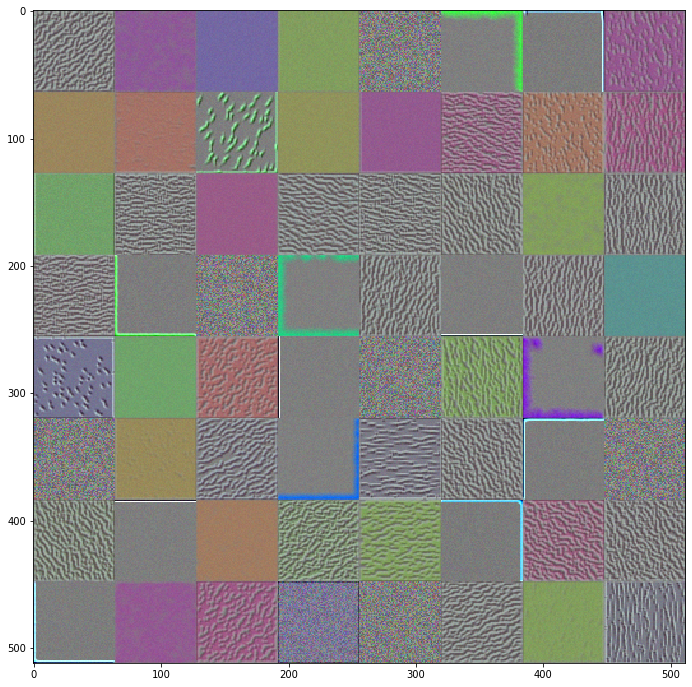

In [19]:
layer_name = 'block1_conv1'
size = 64
# 空图像（全黑色），用于保存结果
results = np.zeros((8 * size, 8 * size, 3)) 
# 遍历results网格的行
for i in range(8): 
    # 遍历results网格的列
    for j in range(8): 
        # 生成layer_name层第i +（j * 8）个过滤器的模式
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size) 
        # （以下6行）将结果放到results网格第(i, j)个方块中
        horizontal_start = i * size       
        horizontal_end = horizontal_start + size                 
        vertical_start = j * size                  
        vertical_end = vertical_start + size                     
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
# 显示results网格
plt.figure(figsize=(12, 12))
plt.imshow(results.astype(np.uint8))

In [ ]:
layer_name = 'block2_conv1'
size = 64
# 空图像（全黑色），用于保存结果
results = np.zeros((8 * size, 8 * size, 3)) 
# 遍历results网格的行
for i in range(8): 
    # 遍历results网格的列
    for j in range(8): 
        # 生成layer_name层第i +（j * 8）个过滤器的模式
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size) 
        # （以下6行）将结果放到results网格第(i, j)个方块中
        horizontal_start = i * size       
        horizontal_end = horizontal_start + size                 
        vertical_start = j * size                  
        vertical_end = vertical_start + size                     
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
# 显示results网格
plt.figure(figsize=(12, 12))
plt.imshow(results.astype(np.uint8))

In [ ]:
layer_name = 'block3_conv1'
size = 64
# 空图像（全黑色），用于保存结果
results = np.zeros((8 * size, 8 * size, 3)) 
# 遍历results网格的行
for i in range(8): 
    # 遍历results网格的列
    for j in range(8): 
        # 生成layer_name层第i +（j * 8）个过滤器的模式
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size) 
        # （以下6行）将结果放到results网格第(i, j)个方块中
        horizontal_start = i * size       
        horizontal_end = horizontal_start + size                 
        vertical_start = j * size                  
        vertical_end = vertical_start + size                     
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
# 显示results网格
plt.figure(figsize=(12, 12))
plt.imshow(results.astype(np.uint8))

In [ ]:
layer_name = 'block4_conv1'
size = 64
# 空图像（全黑色），用于保存结果
results = np.zeros((8 * size, 8 * size, 3)) 
# 遍历results网格的行
for i in range(8): 
    # 遍历results网格的列
    for j in range(8): 
        # 生成layer_name层第i +（j * 8）个过滤器的模式
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size) 
        # （以下6行）将结果放到results网格第(i, j)个方块中
        horizontal_start = i * size       
        horizontal_end = horizontal_start + size                 
        vertical_start = j * size                  
        vertical_end = vertical_start + size                     
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
# 显示results网格
plt.figure(figsize=(12, 12))
plt.imshow(results.astype(np.uint8))

这些过滤器可视化包含卷积神经网络的层如何观察世界的很多信息：卷积神经网络中每一层都学习一组过滤器，以便将其输入表示为过滤器的组合。这类似于傅里叶变换将信号分解为一组余弦函数的过程。随着层数的加深，卷积神经网络中的过滤器变得越来越复杂，越来越精细：
+ 模型第一层（`block1_conv1`）的过滤器对应简单的方向边缘和颜色（还有一些是彩色边缘）
+ `block2_conv1`层的过滤器对应边缘和颜色组合而成的简单纹理
+ 更高层的过滤器类似于自然图像中的纹理：羽毛、眼睛、树叶等

### 5.4.3 可视化类激活的热力图
我还要介绍另一种可视化方法，它有助于了解一张图像的哪一部分让卷积神经网络做出了最终的分类决策。这有助于对卷积神经网络的决策过程进行调试，特别是出现分类错误的情况下。这种方法还可以定位图像中的特定目标。这种通用的技术叫作`类激活图`（CAM，class activation map）可视化，它是指对输入图像生成类激活的热力图。

`类激活热力图`是与特定输出类别相关的二维分数网格，对任何输入图像的每个位置都要进行计算，它表示每个位置对该类别的重要程度。举例来说，对于输入到猫狗分类卷积神经网络的一张图像，CAM可视化可以生成类别“猫”的热力图，表示图像的各个部分与“猫”的相似程度，CAM可视化也会生成类别“狗”的热力图，表示图像的各个部分与“狗”的相似程度。

我们将使用的具体实现方式是“Grad-CAM: visual explanations from deep networks via gradient- based localization”这篇论文中描述的方法。这种方法非常简单：给定一张输入图像，对于一个卷积层的输出特征图，用类别相对于通道的梯度对这个特征图中的每个通道进行加权。直观上来看，理解这个技巧的一种方法是，你是用“每个通道对类别的重要程度”对“输入图像对不同通道的激活强度”的空间图进行加权，从而得到了“输入图像对类别的激活强度”的空间图。
> 该文由`Ramprasaath R. Selvaraju`等人于 2017 年发表

我们再次使用预训练的 VGG16 网络来演示此方法。

In [ ]:
# 注意，网络中包括了密集连接分类器。在前面所有的例子中，我们都舍弃了这个分类器
model = VGG16(weights='imagenet')

`图5-34`显示了两只非洲象的图像，可能是一只母象和它的小象。我们将这张图像转换为`VGG16`模型能够读取的格式：模型在大小为$224 \times 224$的图像上进行训练，这些训练图像都根据`keras.applications.vgg16.preprocess_input`函数中内置的规则进行预处理。因此，我们需要加载图像，将其大小调整为$224 \times 224$，然后将其转换为`float32`格式的`Numpy`张量，并应用这些预处理规则。

<img src="./data/creative_commons_elephant.jpg" style="width:500px;"/>

In [ ]:
img_path = './data/creative_commons_elephant.jpg'

# 大小为224×224的Python图像库（PIL，Python imaging library）图像
img = image.load_img(img_path, target_size=(224, 224))
# 形状为 (224, 224, 3)的float32格式的Numpy数组
x = image.img_to_array(img) 
# 添加一个维度，将数组转换为(1, 224, 224, 3)形状的批量
x = np.expand_dims(x, axis=0) 
# 对批量进行预处理（按通道进行颜色标准化）
x = preprocess_input(x) 

# 在图像上运行预训练的VGG16网络，并将其预测向量解码为人类可读的格式
preds = model.predict(x)
('Predicted:', decode_predictions(preds, top=3)[0])

对这张图像预测的前三个类别分别为：
+ 非洲象（African elephant，92.5%的概率）
+ 长牙动物（tusker，7%的概率）
+ 印度象（Indian elephant，0.4%的概率）

网络识别出图像中包含数量不确定的非洲象。预测向量中被最大激活的元素是对应“非洲象”类别的元素，索引编号为386。

In [ ]:
np.argmax(preds[0])

为了展示图像中哪些部分最像非洲象，我们来使用`Grad-CAM`算法。

In [ ]:
# 预测向量中的“非洲象”元素
african_elephant_output = model.output[:, 386]
# `block5_conv3`层的输出特征图，它是VGG16的最后一个卷积层
last_conv_layer = model.get_layer('block5_conv3')
# “非洲象”类别相对于`block5_conv3`输出特征图的梯度
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
# 形状为(512,)的向量，每个元素是特定特征图通道的梯度平均大小
pooled_grads = K.mean(grads, axis=(0, 1, 2))
# 访问刚刚定义的量：对于给定的样本图像，`pooled_grads`和`block5_conv3`层的输出特征图
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
# 对于两个大象的样本图像，这两个量都是Numpy数组
pooled_grads_value, conv_layer_output_value = iterate([x])
# 将特征图数组的每个通道乘以“这个通道对‘大象’类别的重要程度”
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
# 得到的特征图的逐通道平均值即为类激活的热力图
heatmap = np.mean(conv_layer_output_value, axis=-1)

为了便于可视化，我们还需要将热力图标准化到`0~1`范围内：

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap);

最后，我们可以用`OpenCV`来生成一张图像，将原始图像叠加在刚刚得到的热力图上：

In [ ]:
# We use cv2 to load the original image
img = cv2.imread(img_path)
# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img
# Save the image to disk
cv2.imwrite('./data/elephant_cam.jpg', superimposed_img)

<img src="./data/elephant_cam.jpg" style="width:500px;"/>

这种可视化方法回答了两个重要问题：
+ 网络为什么会认为这张图像中包含一头非洲象？
+ 非洲象在图像中的什么位置？

尤其值得注意的是，小象耳朵的激活强度很大，这可能是网络找到的非洲象和印度象的不同之处。